# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Ц_». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Подготовка данных

Импортируем необходимые библиотеки и классы

In [233]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import (train_test_split, cross_validate, 
                                     cross_val_score, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_curve, roc_auc_score, make_scorer
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.dummy import DummyRegressor

# Импортирую библиотеку для отображения статус-бара
import tqdm

In [234]:
STATE = np.random.RandomState(12345)

In [235]:
try:
    d_train = pd.read_csv('path_to/gold_recovery_train_new.csv')
    d_test  = pd.read_csv('path_to/gold_recovery_test_new.csv')
    d_full  = pd.read_csv('path_to/gold_recovery_full_new.csv')
    print('Прочитали данные с диска')
except:
    d_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    d_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    d_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
    print('Прочитали данные в сети')

Прочитали данные с диска


### 1.1. Посмотрим сводную информацию по датасетам

Вместо стандартного .info() создам функцию для вывода сводной информации по датафрейму

In [236]:
def summary_table(data):
    df = pd.DataFrame({'col_null_count':data.isna().sum()},index=data.isna().sum().index)
    df['col_type']=data.dtypes
    df = df.join(data.describe().transpose())
    df['mean_median']=(df['mean']-df['50%'])/df['50%'] # превышение медианы над средним
    df_style = {'count':'{:.0f}','mean':'{:.2f}','mean_median':'{:.2%}', # словарь для форматирования вывода
                'std':'{:.2f}','min':'{:.1f}','25%':'{:.1f}','50%':'{:.1f}','75%':'{:.1f}','max':'{:.1f}'}
    return df, df_style

Посмотрим сводную информацию по d_full

In [237]:
df_full, df_style = summary_table(d_full)
df_full.style.format(df_style)

,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
date,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
final.output.concentrate_ag,1,float64,19438,5.17,1.37,0.0,4.3,5.1,5.9,16.0,2.02%
final.output.concentrate_pb,1,float64,19438,9.98,1.67,0.0,9.1,10.1,11.0,17.0,-1.22%
final.output.concentrate_sol,211,float64,19228,9.50,2.79,0.0,7.7,9.2,10.9,19.6,3.06%
final.output.concentrate_au,0,float64,19439,44.08,5.13,0.0,43.4,45.0,46.3,52.8,-2.08%
final.output.recovery,0,float64,19439,67.05,10.13,0.0,63.3,68.2,72.7,100.0,-1.65%
final.output.tail_ag,1,float64,19438,9.69,2.33,0.0,8.1,9.7,11.1,19.6,-0.56%
final.output.tail_pb,101,float64,19338,2.71,0.95,0.0,2.0,2.7,3.3,5.8,-1.56%
final.output.tail_sol,6,float64,19433,10.58,2.87,0.0,8.9,10.6,12.1,22.3,-0.36%
final.output.tail_au,0,float64,19439,3.04,0.92,0.0,2.5,3.0,3.6,8.2,1.93%


Также создам список списков, чтобы в дальнейшем не листать ноутбук

In [238]:
lst = []

Сохраним список полей датасета

In [239]:
col_list_full = [column for column in d_full]
lst = lst + ['col_list_full']
len(col_list_full)

87

Видим, что почти в каждом поле датасета есть минимальное количество пропусков. При этом 3 поля:
- rougher.state.floatbank10_e_air
- secondary_cleaner.output.tail_sol
- secondary_cleaner.state.floatbank2_a_air
имеют заметное количесво пропусков.

Ознакомимся с другими датасетами, чтобы принять решение по работе с пропусками.

Видим поля с заметным (более 5%) расхождением медианы и среднего (поле - mean_median). Расхождение сигнализирует о наличии выбросов

Посмотрим сводную информацию по d_test

In [240]:
df_test, df_style = summary_table(d_test)
df_test.style.format(df_style)

,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
date,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
primary_cleaner.input.sulfate,4,float64,5286,174.84,43.03,2.6,147.1,177.8,208.1,266.0,-1.68%
primary_cleaner.input.depressant,5,float64,5285,8.68,3.07,0.0,6.5,8.1,10.0,40.0,7.84%
primary_cleaner.input.feed_size,0,float64,5290,7.27,0.61,5.7,6.9,7.2,7.6,15.5,0.23%
primary_cleaner.input.xanthate,4,float64,5286,1.38,0.64,0.0,0.9,1.2,1.8,4.1,15.55%
primary_cleaner.state.floatbank8_a_air,0,float64,5290,1539.49,116.80,0.0,1498.9,1585.1,1602.1,2103.1,-2.88%
primary_cleaner.state.floatbank8_a_level,0,float64,5290,-497.67,19.95,-795.3,-500.4,-500.0,-499.6,-57.2,-0.46%
primary_cleaner.state.floatbank8_b_air,0,float64,5290,1545.17,122.22,0.0,1499.0,1595.6,1602.3,1813.1,-3.16%
primary_cleaner.state.floatbank8_b_level,0,float64,5290,-500.27,32.97,-800.0,-500.7,-500.0,-499.3,-142.5,0.05%
primary_cleaner.state.floatbank8_c_air,0,float64,5290,1527.27,122.54,0.0,1473.2,1549.6,1601.1,1715.1,-1.44%


In [241]:
col_list_test = [column for column in d_test]
lst = lst + ['col_list_test']
len(col_list_test)

53

Видим, что в тестовом датасете практически отсутутствуют пропуски.

Посмотрим сводную информацию по d_train

In [242]:
df_train, df_style = summary_table(d_train)
df_train.style.format(df_style)

,col_null_count,col_type,count,mean,std,min,25%,50%,75%,max,mean_median
date,0,object,nan,nan,nan,nan,nan,nan,nan,nan,nan%
final.output.concentrate_ag,1,float64,14148,5.14,1.37,0.0,4.2,5.0,5.9,16.0,2.95%
final.output.concentrate_pb,1,float64,14148,10.13,1.65,0.0,9.3,10.3,11.2,17.0,-1.59%
final.output.concentrate_sol,211,float64,13938,9.20,2.79,0.0,7.5,8.8,10.5,18.1,4.04%
final.output.concentrate_au,0,float64,14149,44.00,4.91,0.0,43.3,44.9,46.2,52.8,-1.94%
final.output.recovery,0,float64,14149,66.52,10.30,0.0,62.5,67.4,72.3,100.0,-1.36%
final.output.tail_ag,0,float64,14149,9.61,2.32,0.0,8.0,9.5,11.0,19.6,1.34%
final.output.tail_pb,100,float64,14049,2.60,0.97,0.0,1.9,2.6,3.2,5.6,0.20%
final.output.tail_sol,5,float64,14144,10.51,3.00,0.0,8.8,10.5,11.9,22.3,-0.02%
final.output.tail_au,0,float64,14149,2.92,0.90,0.0,2.4,2.9,3.4,8.2,2.36%


In [243]:
# сохраним список полей
col_list_train = [column for column in d_train]
lst = lst + ['col_list_train']
len(col_list_train)

87

Видим, что в обучающей выборке имеется значительное количество пропусков

### Сравним поля датасетов

In [244]:
# оценим количество сэмплов в выборках
len(d_full)-len(d_test)-len(d_train)

0

Найдем непересекающиеся поля в датасетах. На всякий случай посмотрю насколько full - полный.

In [245]:
print('Количество полей тестовой выборки, не входящих в полную',
      len([x for x in col_list_test if x not in col_list_full]))
print('Количество полей обучающей выборки, не входящих в полную',
      len([x for x in col_list_train if x not in col_list_full]))

Количество полей тестовой выборки, не входящих в полную 0
Количество полей обучающей выборки, не входящих в полную 0


Выборка full оправдывает свое название

Также сравню train c test

In [246]:
print('Количество полей тестовой выборки, не входящих в обучающую',
len([x for x in col_list_test if x not in col_list_train]))
print('Количество полей обучающей выборки, не входящих в тестовую',
len([x for x in col_list_train if x not in col_list_test]))

Количество полей тестовой выборки, не входящих в обучающую 0
Количество полей обучающей выборки, не входящих в тестовую 34


In [247]:
print('Количество полей обучающей общей, не входящих в обучающую',
len([x for x in col_list_full if x not in col_list_train]))

Количество полей обучающей общей, не входящих в обучающую 0


Видим, что поля в полной (full) и обучающей (train) выборке полностью совпадают.

Множество полей тестовой выборки меньше полной (как и обучающей) на 34 шт.

Проверим также корректность разбиения по сэмплам на тестовую и обучающую выборки: посмотрим пересечение датасетов по дате.

In [248]:
len(d_train.merge(d_test,on='date'))

0

Тестовая и обучающая выборка не пересекаются по полю даты

In [249]:
print('Количество отличающихся по дате сэмплов из обучающей и полной выборок',
      len(d_train)-len(d_train.merge(d_full,on='date')))
print('Количество отличающихся по любым полям сэмплов из обучающей и полной выборок',
      len(d_train)-len(d_train.merge(d_full)))

Количество отличающихся по дате сэмплов из обучающей и полной выборок 0
Количество отличающихся по любым полям сэмплов из обучающей и полной выборок 3092


In [250]:
print('Количество отличающихся по дате сэмплов из тестовой и полной выборок',
len(d_test)-len(d_test.merge(d_full,on='date')))
print('Количество отличающихся по любым полям сэмплов из тестовой и полной выборок',
len(d_test)-len(d_test.merge(d_full)))

Количество отличающихся по дате сэмплов из тестовой и полной выборок 0
Количество отличающихся по любым полям сэмплов из тестовой и полной выборок 0


Множества дат сэмплов обучающей  выборки полностью включены в полную выборку. Но при "связке" датасетов по всем полям имеем значительное количество отличающихся сэмплов.

Тестовая же выборка является подмножеством полной выборки без исключений (совпадение по всем полям)

Теперь, когда получено предварительное понимание о составах и пересечениях датасетов, перейдем к следующим заданиям

### 1.2. Правильность расчета эффективности обогащения
Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

Посмотрим в каких полях "есть" золото на этапе rougher

In [251]:
[x for x in col_list_train if 'rougher' in x and 'au' in x]

['rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au']

Видим, что требуемые для расчета поля это:

In [252]:
# Recovery = 100*C*(F-T)/F*(C-T)               # формула
C = d_train['rougher.output.concentrate_au']   # доля золота в концентрате после флотации/очистки
F = d_train['rougher.input.feed_au']           # доля золота в сырье/концентрате до флотации/очистки
T = d_train['rougher.output.tail_au']          # доля золота в отвальных хвостах после флотации/очистки

In [253]:
d_train['rougher.output.recovery_est'] = 100*(C*(F-T))/(F*(C-T)) # Recovery estimated

In [254]:
d_train['rougher.output.recovery'].mean()

82.70450164550267

In [255]:
d_train['rougher.output.recovery_est'].mean()

82.70450164550269

In [256]:
mae = (abs(d_train['rougher.output.recovery_est']-d_train['rougher.output.recovery']).sum())/len(d_train)
mae

1.1131451184435918e-14

Среднее абсолютное отклонение близко к нулю нулю. Т.о. можно считать значения поля rougher.output.recovery правильными

### Проанализируйте признаки, недоступные в тестовой выборке.
Что это за параметры? К какому типу относятся?

Как отметил выше - множество полей тестовой выборки меньше полной (как и обучающей) на 34 шт. Посмотим эти поля

In [257]:
col_list_not_test = [x for x in col_list_train if x not in col_list_test]
lst = lst + ['col_list_not_test']
col_list_not_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

Поля, которые не входят в тестовую выборку относятся типам параметра 'output', 'calculation'. При этом поля с данными типами параметров вообще отсутствуют в тестовой выборке. Т.о. можно считать, что тестовая выборка не имеет данных с результатами тех.процесса, т.е. смоделирована ситуация приближенная к "боевой"- мы что то "загружаем" в тех.процесс но не знаем, что получается на выходе.

Также тестовая выборка не содержит наши целевые показатели:
- rougher.output.recovery
- final.output.recovery

Добавим целевые поля в тестовую выборку

In [258]:
d_test = d_test.merge(d_full[['date']+['rougher.output.recovery','final.output.recovery']],on='date')

Приведу обучающую выборку в соответствие с тестовой - оставлю в трэйне только поля из тестовой выборки.

In [259]:
col_list_test = [column for column in d_test]
# col_list_test
col_list_train = col_list_test

In [260]:
d_train = d_train[col_list_train]
# [column for column in d_train]

### 1.4. Проведите предобработку данных.

Посмотрим дубликаты

In [261]:
print('Количество дубликатов в обучающей выборке',d_train.duplicated().sum())
print('количество дубликатов в тестовой выборке',d_test.duplicated().sum())
print('количество дубликатов в общей выборке',d_test.duplicated().sum())

Количество дубликатов в обучающей выборке 0
количество дубликатов в тестовой выборке 0
количество дубликатов в общей выборке 0


Проведем замену пропусков методом ffill (по предыдущему значению).

In [262]:
# заполним пропуски
d_train = d_train.fillna(method='ffill')
d_test = d_test.fillna(method='ffill')

Посмотрим диаграммы размаха по этапам. Для того, чтобы возможно было уместить все данные на одном графике, нормализуем числовые поля таблицы (создадим функцию нормализации)

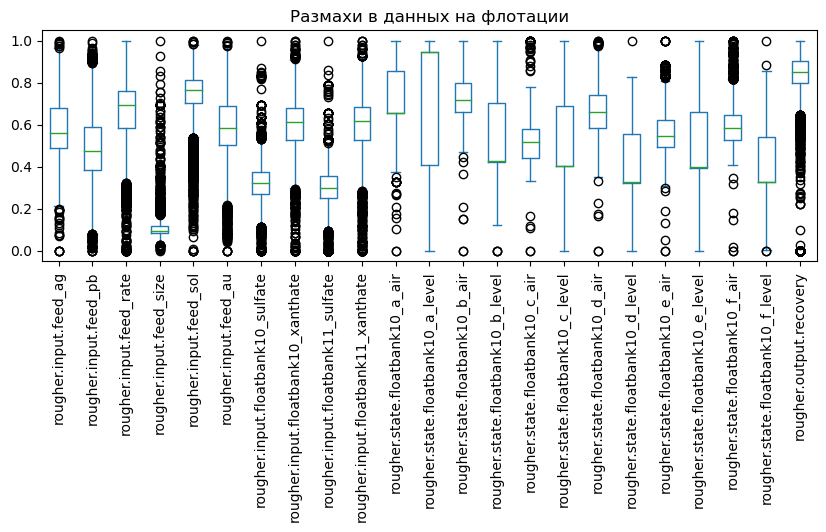

In [263]:
def data_norm(data_to_norm):
    data_norm = pd.DataFrame()
    for clmn in [column for column in data_to_norm]:
        if (data_to_norm.dtypes[clmn] != 'object' and
            data_to_norm.dtypes[clmn] != 'bool' and
            data_to_norm.dtypes[clmn] != 'datetime64[ns]'):
            data_norm[clmn] = data_to_norm[clmn]

    data_norm = (data_norm-data_norm.min())/(data_norm.max()-data_norm.min())
    return data_norm
rough_list = [x for x in col_list_train if 'rougher' in x]
lst = lst + ['rough_list']
data_norm(d_train[rough_list]).plot(kind='box', figsize=(10,3),rot=90, title='Размахи в данных на флотации');

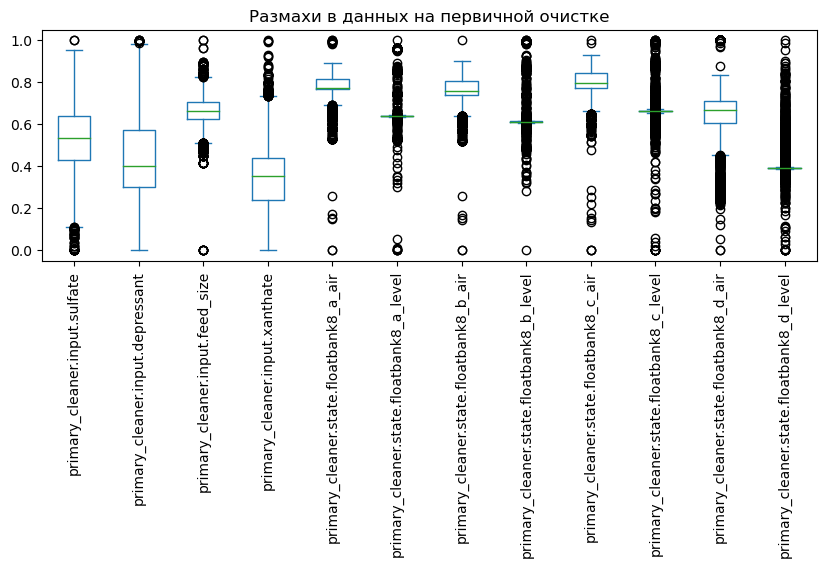

In [264]:
primary_cleaner_list = [x for x in col_list_train if 'primary_cleaner' in x]
lst = lst + ['primary_cleaner_list']
data_norm(d_train[primary_cleaner_list]).plot(kind='box',
                        figsize=(10,3),rot=90, title='Размахи в данных на первичной очистке');

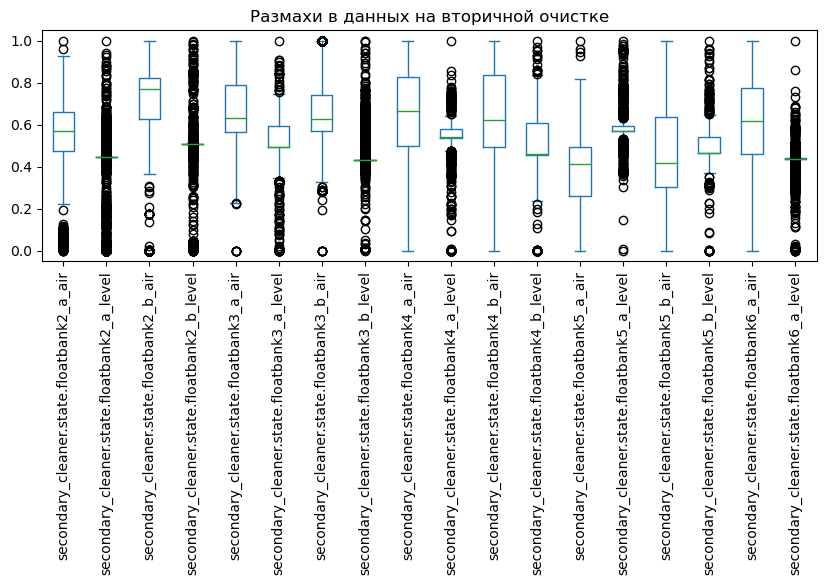

In [265]:
secondary_cleaner_list = [x for x in col_list_train if 'secondary_cleaner' in x]
lst = lst + ['secondary_cleaner_list']
data_norm(d_train[secondary_cleaner_list]).plot(kind='box',
                        figsize=(10,3),rot=90, title='Размахи в данных на вторичной очистке');

Видим, что на всех этапах значения почти всех полей имеют выбросы. Очевидно, что удаление выбросов значительно сократит размер датасета. Наука о данных учит нас не выбрасывать выбросы при использовании этих данных в машинном обучении. Возможно, информация о размахах и функция нормировки пригодится дальше при сравнениии распределений на разных этапах.

Поскольку мы будем смотреть несколько моделей включая линейну регрессию, необходимо проверить данные на мультиколлинеарность. При использовании метода .corr() с выводом только значений больших заданного уровня, мы получим достаточно большую (и возможно разреженную) матрицу. Поэтому подготовим функцию для вывода пар полей признаков с коэффициентом корреляции большим или равным заданной отсечки

In [266]:
cutoff = 0.8
def pairs_corr(data,cutoff,is_target=False):
    data_corr_cutoff = pd.DataFrame()
    if is_target: col_list = [column for column in data if 'date' not in column]
    else:
        col_list = [column for column in data if 'date' not in column
                and 'rougher.output.recovery' not in column
                and 'final.output.recovery' not in column
               ]
    for c in col_list:
        for m in col_list:
            if c != m:
                field = c+'_XXX_'+m
                dleif = m+'_XXX_'+c
                if field not in data_corr_cutoff.index and dleif not in data_corr_cutoff.index:
                    crr = data[c].corr(data[m])
                    if crr >= cutoff:
                        data_corr_cutoff.loc[field,'corr'] = crr
                        data_corr_cutoff.loc[field,'col1'] = c
                        data_corr_cutoff.loc[field,'col2'] = m
    return data_corr_cutoff

# посмотрим корреляции с включением таргетов, чтобы не "отсеять" важные поля
d_train_corr_cutoff = pairs_corr(d_train,cutoff,True)

In [267]:
pd.set_option('display.max_rows', None)
display(d_train_corr_cutoff)
pd.reset_option('display.max_rows')

,corr,col1,col2
primary_cleaner.state.floatbank8_a_air_XXX_primary_cleaner.state.floatbank8_b_air,0.945319,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_a_air_XXX_primary_cleaner.state.floatbank8_c_air,0.934486,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_a_level_XXX_primary_cleaner.state.floatbank8_b_level,0.958855,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_a_level_XXX_primary_cleaner.state.floatbank8_c_level,0.958372,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_b_air_XXX_primary_cleaner.state.floatbank8_c_air,0.939579,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_b_level_XXX_primary_cleaner.state.floatbank8_c_level,0.938447,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_level
rougher.input.feed_ag_XXX_rougher.input.feed_au,0.845670,rougher.input.feed_ag,rougher.input.feed_au
rougher.input.floatbank10_xanthate_XXX_rougher.input.floatbank11_xanthate,0.891798,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate
rougher.state.floatbank10_b_air_XXX_rougher.state.floatbank10_c_air,0.937170,rougher.state.floatbank10_b_air,rougher.state.floatbank10_c_air
rougher.state.floatbank10_b_air_XXX_rougher.state.floatbank10_d_air,0.928074,rougher.state.floatbank10_b_air,rougher.state.floatbank10_d_air


Видим, что трагетов в списке сильнозависимых полей нет

In [268]:
multicol_list = d_train_corr_cutoff['col1'].tolist()
lst = lst + ['multicol_list']
# multicol_list

Видим, что значительная часть полей признаков имеет условно высокий (>=80%) уровень корреляции. Это негативно повлияет на линейные модели.

Поэтому при работе с лин.регрессией необходимо будет исключить половину полей из найденных выше пар.

Также исключение части сильнозависимых признаков должно "облегчить" модель - уменьшить время поиска гиперпараметров. Но поскольку данные могут понадобиться в блоке "Анализ данных", то в данный момент эти поля удалять не буду.

## Анализ данных

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

Смотреть буду полный датафрейм

Определим поля с информацией по концентрации для золота. Посмотрим все "золотые" поля

In [269]:
[x for x in col_list_full if '_au' in x]

['final.output.concentrate_au',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'rougher.output.tail_au',
 'secondary_cleaner.output.tail_au']

Список полей с данными по концентрации

In [270]:
conc_list_au = ['rougher.input.feed_au','rougher.output.concentrate_au',
                'primary_cleaner.output.concentrate_au','final.output.concentrate_au']
lst = lst + ['conc_list_au']

Составим такие же списки для серебра и свинца

In [271]:
[x for x in col_list_full if '_ag' in x]

['final.output.concentrate_ag',
 'final.output.tail_ag',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.tail_ag',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_ag',
 'rougher.output.tail_ag',
 'secondary_cleaner.output.tail_ag']

In [272]:
conc_list_ag = ['rougher.input.feed_ag','rougher.output.concentrate_ag',
                'primary_cleaner.output.concentrate_ag','final.output.concentrate_ag']
lst = lst + ["conc_list_ag"]

In [273]:
[x for x in col_list_full if '_pb' in x]

['final.output.concentrate_pb',
 'final.output.tail_pb',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.tail_pb',
 'rougher.calculation.au_pb_ratio',
 'rougher.input.feed_pb',
 'rougher.output.concentrate_pb',
 'rougher.output.tail_pb',
 'secondary_cleaner.output.tail_pb']

In [274]:
conc_list_pb = ['rougher.input.feed_pb','rougher.output.concentrate_pb',
                 'primary_cleaner.output.concentrate_pb','final.output.concentrate_pb']
lst = lst + ['conc_list_pb']

Построим гистограммы для разных этапов

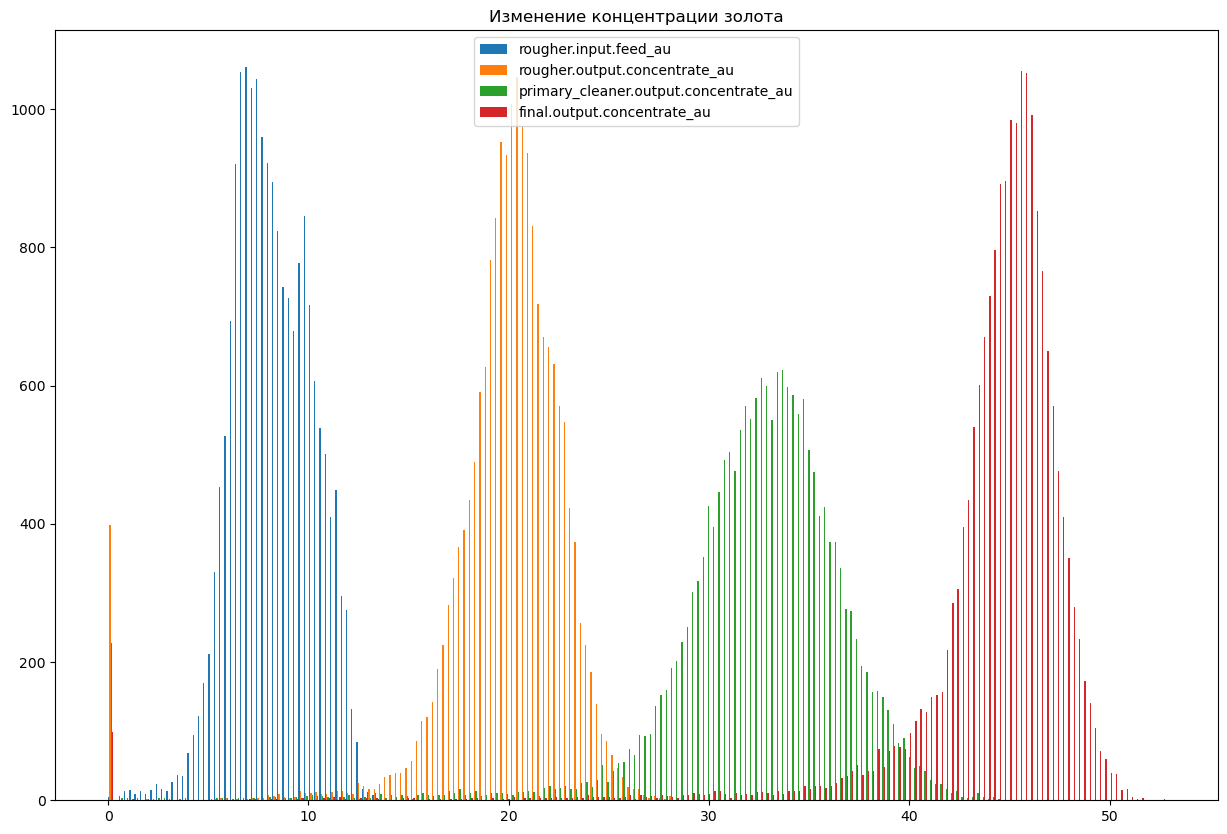

In [275]:
plt.figure(figsize=(15,10))
plt.hist(d_full[conc_list_au],bins=200,rwidth=1)
plt.title('Изменение концентрации золота')
plt.legend(conc_list_au,loc = 'upper center')
plt.show();

In [276]:
d_full[conc_list_au].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_au,19439.0,8.266097,1.955092,0.01,6.854384,8.125839,9.769917,13.731330
rougher.output.concentrate_au,19439.0,19.772000,3.753600,0.00,18.802523,20.280214,21.717843,28.824507
primary_cleaner.output.concentrate_au,19439.0,32.119400,5.627611,0.00,30.463140,32.841295,35.048006,45.933934
final.output.concentrate_au,19439.0,44.076513,5.129784,0.00,43.402215,45.011244,46.275313,52.756638


Видим, что концентрация золота повышается на каждом этапе (визуально по графикам  по всем стат метрикам). Это говорит о "правильности" тех процесса.

Визуально форма распределения сохраняется. При этом стандартное отклонение сильно возрастает от этапа флотации к первичной обработке. Что вероятно связано с более стабильным и одновременно низким уровнем содержания металла в первичном сырье.

На финальном этапе стандартное отклонение снижается. Что означает "стабилизацию" процесса на данном этапе.

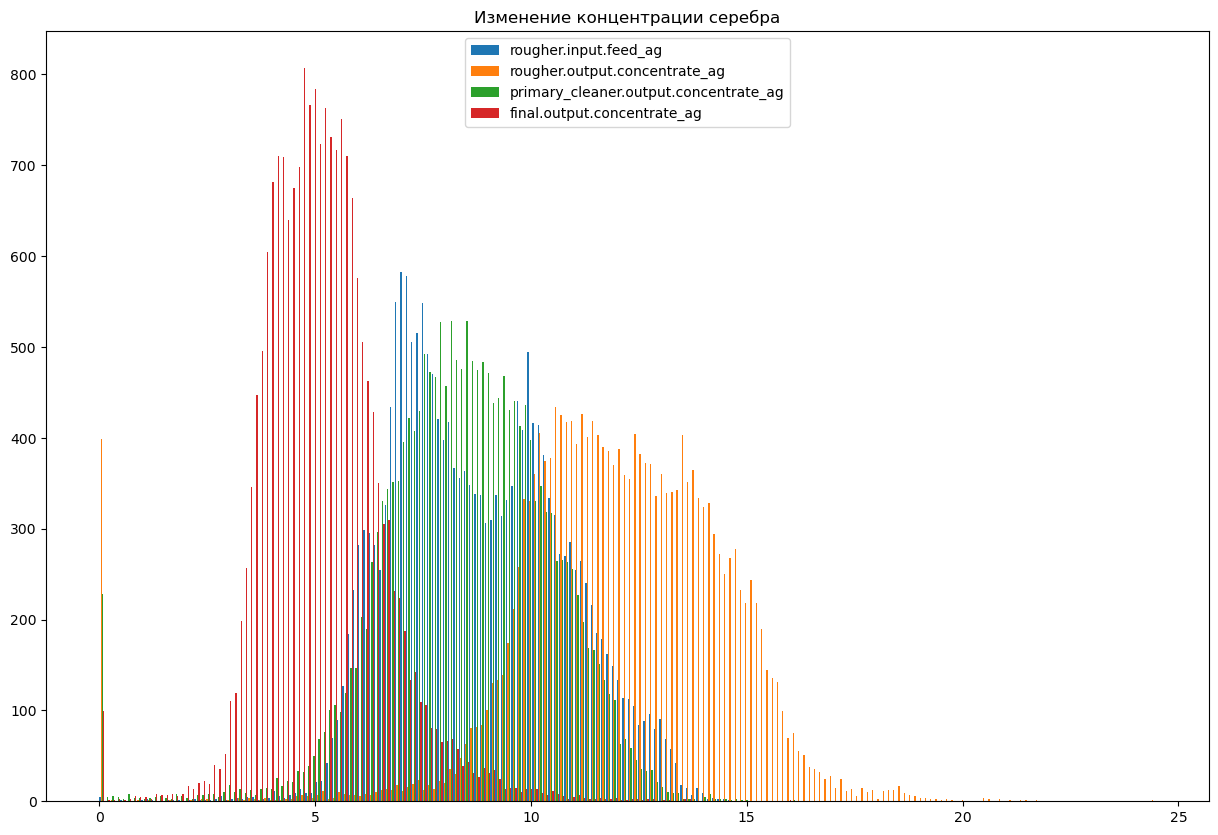

In [277]:
plt.figure(figsize=(15,10))
plt.hist(d_full[conc_list_ag],bins=200,rwidth=1)
plt.title('Изменение концентрации серебра')
plt.legend(conc_list_ag,loc = 'upper center')
plt.show();

In [278]:
d_full[conc_list_ag].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_ag,19439.0,8.794927,1.936847,0.01,7.237967,8.593574,10.213771,14.596026
rougher.output.concentrate_ag,19439.0,11.994759,2.733862,0.00,10.628337,12.098115,13.736996,24.480271
primary_cleaner.output.concentrate_ag,19439.0,8.442408,2.054465,0.00,7.263288,8.507298,9.809001,16.081632
final.output.concentrate_ag,19438.0,5.168470,1.372348,0.00,4.251240,5.066094,5.895527,16.001945


Серебро имеет другую динамику изменения концентрации. По всей видимости тех процесс устроен так, что серебро максимально извлекается уже на начальных этапах. На этапе флотации и первичной обработки наблюдается максимальная концентрация, которая заметно снижается к финалу.

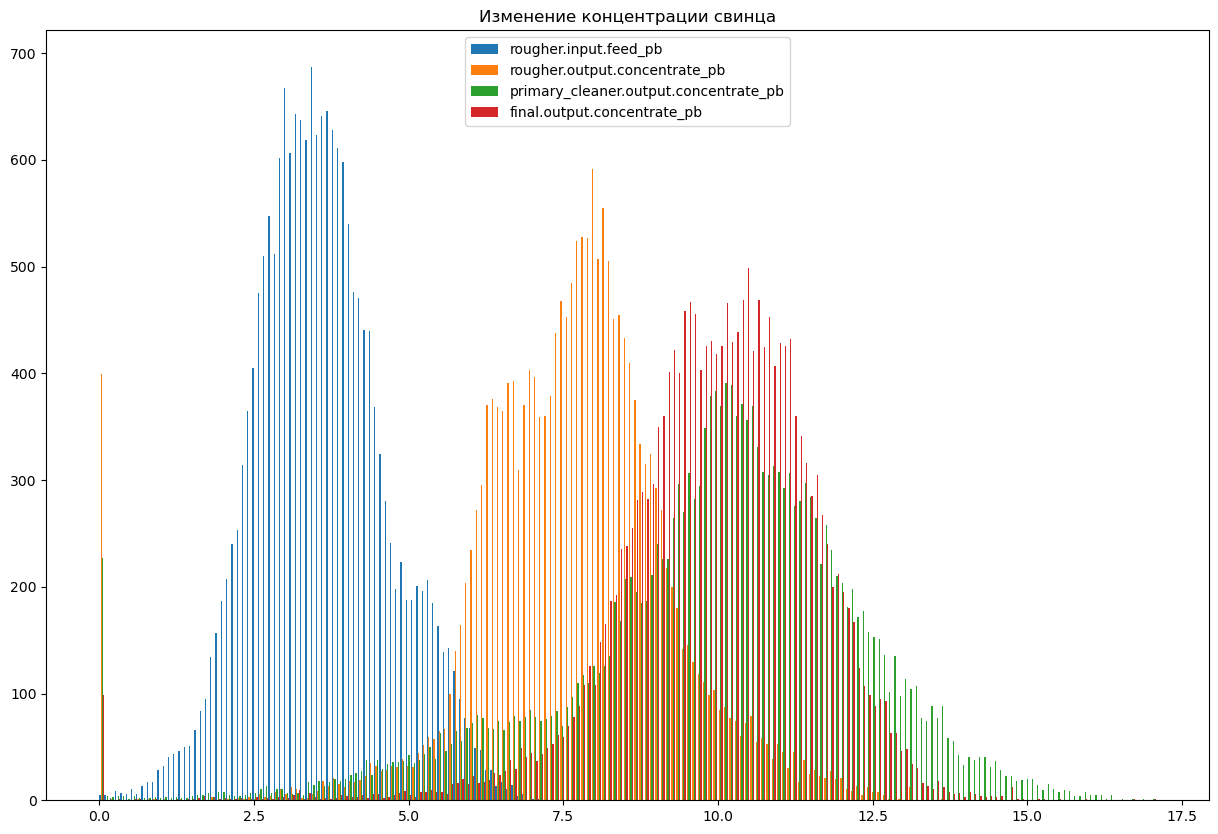

In [279]:
plt.figure(figsize=(15,10))
plt.hist(d_full[conc_list_pb],bins=200,rwidth=1)
plt.title('Изменение концентрации свинца')
plt.legend(conc_list_pb,loc = 'upper center')
plt.show();

In [280]:
d_full[conc_list_pb].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rougher.input.feed_pb,19339.0,3.598085,1.049486,0.01,2.887280,3.534895,4.244161,7.142594
rougher.output.concentrate_pb,19439.0,7.606272,1.796757,0.00,6.725987,7.742580,8.565199,13.617072
primary_cleaner.output.concentrate_pb,19323.0,9.829530,2.556843,0.00,8.702328,10.152433,11.424971,17.081278
final.output.concentrate_pb,19438.0,9.978895,1.669240,0.00,9.137262,10.102433,11.035769,17.031899


Видим, что концентрация свинца растет от флотации к первичной обработке. И на двух последних этапах концентрация и стат.метрики распределения (кроме стандартного отклонения, которое снижается также как в золоте) не меняются

Также необходимо отметить заметное скопление значений равных нулю для всех этапов, это может говорить о наличии ошибок измерений.

Удалим нулевые данные

In [281]:
idtr = []
idte = []
for c in conc_list_au + conc_list_ag + conc_list_pb:
    idx = d_full[d_full[c]==0].index
    d_full = d_full[d_full[c]!=0]
    idtr = idtr + [x for x in d_train.index if x in idx]
    idte = idte + [x for x in d_test.index if x in idx]
d_train = d_train.drop(index=idtr)
d_test = d_test.drop(index=idte)

### 2.2.  Сравните распределения размеров гранул сырья на обучающей и тестовой выборках.
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

In [282]:
[x for x in col_list_train if 'feed' in x and 'size' in x]

['primary_cleaner.input.feed_size', 'rougher.input.feed_size']

Нам нужно поле 'rougher.input.feed_size'

In [283]:
def feed_size(d_train,d_test):
    plt.figure(figsize=(15,8))
    plt.hist(d_test['rougher.input.feed_size'],density=True, bins=100,alpha=0.3,rwidth=1,label='test feed size')
    plt.hist(d_train['rougher.input.feed_size'],bins=100,density=True,alpha=0.3,rwidth=1,label='train feed size')
    plt.title('Изменение концентрации свинца')
    plt.legend(loc = 'upper center')
    plt.show();
    return

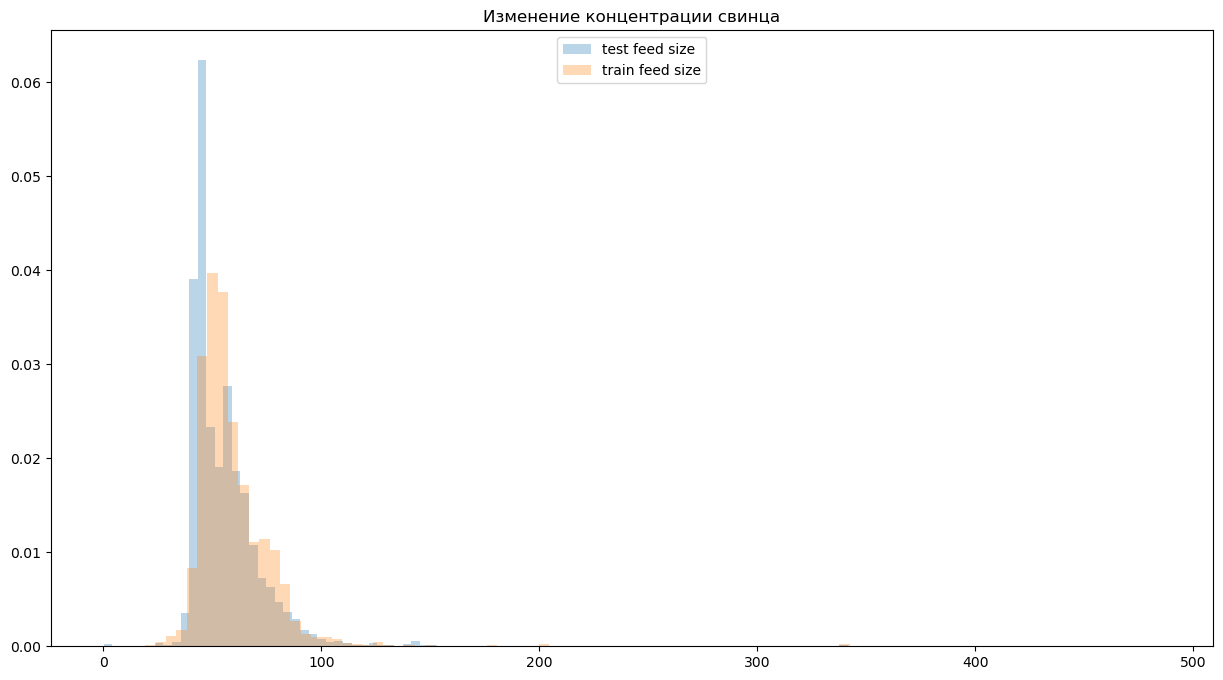

In [284]:
feed_size(d_train,d_test)

In [285]:
pd.concat((d_train['rougher.input.feed_size'].describe(),d_test['rougher.input.feed_size'].describe()),axis=1)

,rougher.input.feed_size,rougher.input.feed_size
count,13727.000000,5157.000000
mean,60.125528,55.604179
std,23.159527,18.951449
min,9.659576,0.046369
25%,48.967067,43.866028
50%,55.201194,50.515522
75%,65.741979,61.751304
max,484.967466,392.494040


Видим, что распределения отличаются по форме и по статметрикам. Решением может быть стандартное масштабирование.

Написал функцию для создания датафреймов по соответствующим спискам. Также в эту функцию включу этап масштабирования данных

In [286]:
# f_list список фичей, t_list - поле таргета
def datasets(f_list,t_list, to_scale=True):
    features_train = d_train[f_list]
    features_test = d_test[f_list]
    if to_scale:
        stand_scaler_train = StandardScaler()
        # масштабируем трэйн фичи
        features_train[f_list] = stand_scaler_train.fit_transform(features_train[f_list])
        # масштабируем тест фичи скалером, обученным на трэйне
        features_test[f_list] = stand_scaler_train.transform(features_test[f_list])
    # таргеты естественно не масштабируются
    target_train = d_train[t_list]
    target_test = d_test[t_list]
    return features_train, target_train, features_test, target_test

In [287]:
# Создадим датасеты с масштабированием и посмотрим концентрацию 

In [288]:
lst

['col_list_full',
 'col_list_test',
 'col_list_train',
 'col_list_not_test',
 'rough_list',
 'primary_cleaner_list',
 'secondary_cleaner_list',
 'multicol_list',
 'conc_list_au',
 'conc_list_ag',
 'conc_list_pb']

In [289]:
# удалим из списка поле с датой
col_list_train = [x for x in col_list_train if x !='date']

In [290]:
features_train, target_train, features_test, target_test = datasets(col_list_train,col_list_train, to_scale=True)

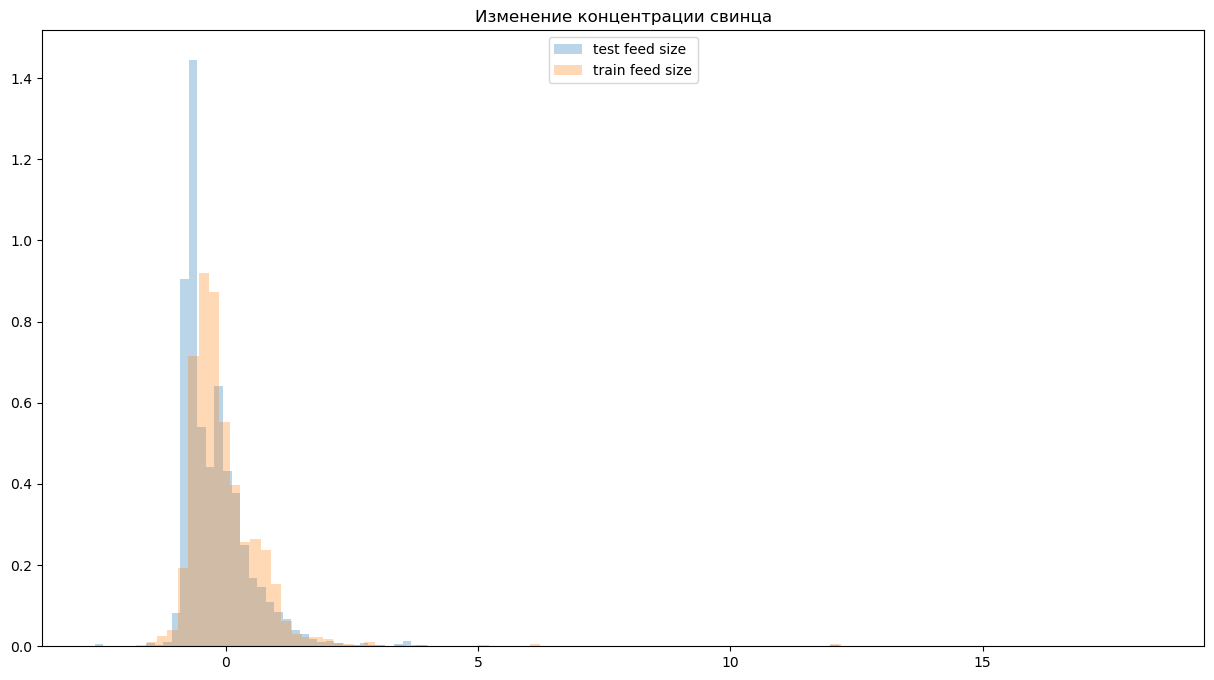

In [291]:
# посмотрим теперь на распределение feed_size
feed_size(features_train,features_test)

In [292]:
pd.concat((features_train['rougher.input.feed_size'].describe(),features_test['rougher.input.feed_size'].describe()),axis=1)

,rougher.input.feed_size,rougher.input.feed_size
count,1.372700e+04,5157.000000
mean,-5.982280e-16,-0.195233
std,1.000036e+00,0.818330
min,-2.179137e+00,-2.594239
25%,-4.818262e-01,-0.702091
50%,-2.126344e-01,-0.414963
75%,2.425203e-01,0.070202
max,1.834482e+01,14.351788


Форма распределений не изменилась. Но масштабирование сделало статметрики распределений менее различными.

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях:
в сырье, в черновом и финальном концентратах.

Посмотрим необходимые поля и рассчитаем необходимые данные

In [293]:
display(conc_list_au)
display(conc_list_ag)
display(conc_list_pb)

['rougher.input.feed_au',
 'rougher.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'final.output.concentrate_au']

['rougher.input.feed_ag',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_ag']

['rougher.input.feed_pb',
 'rougher.output.concentrate_pb',
 'primary_cleaner.output.concentrate_pb',
 'final.output.concentrate_pb']

In [294]:
d_conc = pd.DataFrame()
d_conc['feed'] = (d_full['rougher.input.feed_au']+
        d_full['rougher.input.feed_ag']+d_full['rougher.input.feed_pb'])
d_conc['rougher'] = (d_full['rougher.output.concentrate_au']+
        d_full['rougher.output.concentrate_ag']+d_full['rougher.output.concentrate_pb'])
d_conc['primary'] = (d_full['primary_cleaner.output.concentrate_au']+
        d_full['primary_cleaner.output.concentrate_ag']+d_full['primary_cleaner.output.concentrate_pb'])
d_conc['final'] = (d_full['final.output.concentrate_au']+
        d_full['final.output.concentrate_ag']+d_full['final.output.concentrate_pb'])
stages = ['feed','rougher','primary','final']

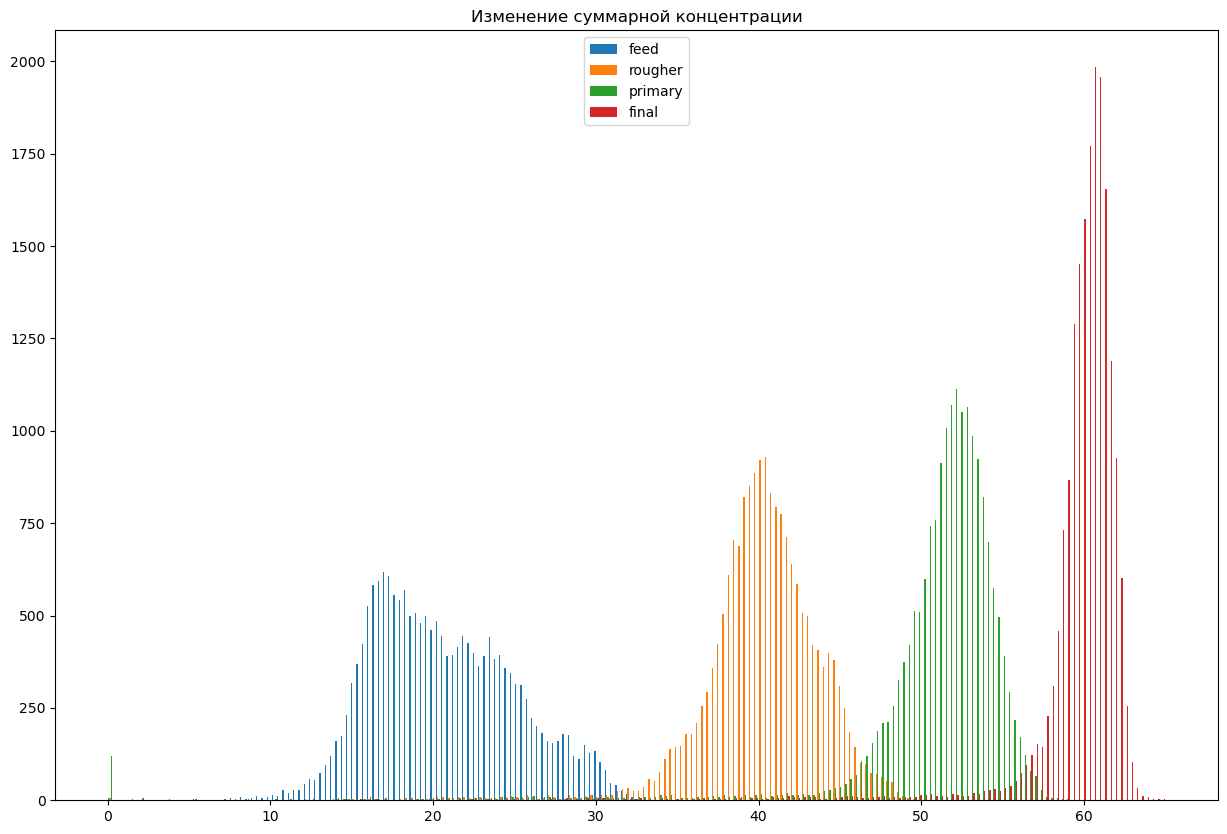

In [295]:
plt.figure(figsize=(15,10))
plt.hist(d_conc,bins=200,rwidth=1)
plt.title('Изменение суммарной концентрации')
plt.legend(stages,loc = 'upper center')
plt.show();

In [296]:
d_conc.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
feed,18748.0,20.685161,4.404718,0.03,17.258681,20.171461,23.809742,33.498784
rougher,18848.0,40.188296,3.896835,0.03,38.526517,40.369255,42.406799,55.568687
primary,18750.0,50.665721,6.570175,0.03,50.105760,51.911403,53.359246,60.106566
final,18847.0,59.523013,4.340077,0.03,59.305841,60.301079,61.087050,64.968881


Можно сделать вывод, что динамика общей концентрации веществ соответствует динамике концентрации золота. Как визуально так и по стат метрикам

In [297]:
stages

['feed', 'rougher', 'primary', 'final']

In [298]:
idtrain = []
idtest  = []
idfull  = []
print('Значения которые попадают в квантильный интервал от 0% до 0.5%')
for c in stages:
    idx = d_conc[d_conc[c]<=d_conc[c].quantile(0.005)].index
    idfull  = idfull  + [x for x in d_full.index if x in idx]
    idtrain = idtrain + [x for x in d_train.index if x in idx]
    idtest  = idtest  + [x for x in d_test.index if x in idx]
#     
    print('Стадия',c,'min:',round(d_conc.loc[idx,c].min(),4),
          'mean:',round(d_conc.loc[idx,c].mean(),4),'max:',round(d_conc.loc[idx,c].max(),4))

print()
print('Доля таких мизеров в общей выборке',round(len(idfull)/len(d_full),4))
print('Доля таких мизеров в test выборке',round(len(idtest)/len(d_test),4))
print('Доля таких мизеров в test выборке',round(len(idtrain)/len(d_train),4))
d_full = d_full.drop(index=idfull)
d_train = d_train.drop(index=idtrain)
d_test = d_test.drop(index=idtest)

Значения которые попадают в квантильный интервал от 0% до 0.5%
Стадия feed min: 0.03 mean: 8.192 max: 10.5797
Стадия rougher min: 0.03 mean: 15.159 max: 20.3362
Стадия primary min: 0.03 mean: 0.03 max: 0.03
Стадия final min: 0.03 mean: 18.0333 max: 27.0149

Доля таких мизеров в общей выборке 0.0213
Доля таких мизеров в test выборке 0.0099
Доля таких мизеров в test выборке 0.0124


## Модель

Подготовим датасеты с признаками и целевыми значениями

In [299]:
# посмотрим список списков
lst

['col_list_full',
 'col_list_test',
 'col_list_train',
 'col_list_not_test',
 'rough_list',
 'primary_cleaner_list',
 'secondary_cleaner_list',
 'multicol_list',
 'conc_list_au',
 'conc_list_ag',
 'conc_list_pb']

Списко целевых значений

In [300]:
target_list = ['rougher.output.recovery','final.output.recovery']
lst = lst + ['target_list']

Поскольку работе с мультитаргетами мы еще не обучены, прогнозировать таргеты будем отдельно

In [301]:
targ_rough = 'rougher.output.recovery'
targ_fin = 'final.output.recovery'
lst = lst + ['targ_rough'] + ['targ_fin']

Признаки- общий список.

In [302]:
feat_list_full = [x for x in col_list_train if (x not in target_list) and (x != 'date')]
lst = lst + ['feat_list_full']
# feat_list_full

Поскольку на значения показателя 'rougher.output.recovery' могут влиять только показатели сформированные до стадии rougher, соответственно в списке признаков дл данного таргета необходимо оставить только поля этапа rougher.

In [303]:
feat_list_rough = [x for x in feat_list_full if ('rougher' in x)]
lst = lst + ['feat_list_rough']
# feat_list_rough

На целевой показатель 'final.output.recovery' влияют все предыдущии стадии процесса. Поэтому список признаков здесь будет равен общему списку признаков feat_list_full

Создадим списки немультиколлинеарных признаков

In [304]:
feat_list_full_notmulti = [x for x in feat_list_full if x not in multicol_list]
lst = lst + ['feat_list_full_notmulti']

Для признаков этапа rougher удаление мультиколл.полей может быть опасным, т.к. если при удалении одного поля из пары, второе поле пары не будет относиться к этапу rogher, тем самым мы можем неоправдано полностью исключить из списка признаков часть полей. Посмотрим еще раз на пары:

In [305]:
display(d_train_corr_cutoff)

,corr,col1,col2
primary_cleaner.state.floatbank8_a_air_XXX_primary_cleaner.state.floatbank8_b_air,0.945319,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_b_air
primary_cleaner.state.floatbank8_a_air_XXX_primary_cleaner.state.floatbank8_c_air,0.934486,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_a_level_XXX_primary_cleaner.state.floatbank8_b_level,0.958855,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_level
primary_cleaner.state.floatbank8_a_level_XXX_primary_cleaner.state.floatbank8_c_level,0.958372,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_c_level
primary_cleaner.state.floatbank8_b_air_XXX_primary_cleaner.state.floatbank8_c_air,0.939579,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_c_air
primary_cleaner.state.floatbank8_b_level_XXX_primary_cleaner.state.floatbank8_c_level,0.938447,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_level
rougher.input.feed_ag_XXX_rougher.input.feed_au,0.845670,rougher.input.feed_ag,rougher.input.feed_au
rougher.input.floatbank10_xanthate_XXX_rougher.input.floatbank11_xanthate,0.891798,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate
rougher.state.floatbank10_b_air_XXX_rougher.state.floatbank10_c_air,0.937170,rougher.state.floatbank10_b_air,rougher.state.floatbank10_c_air
rougher.state.floatbank10_b_air_XXX_rougher.state.floatbank10_d_air,0.928074,rougher.state.floatbank10_b_air,rougher.state.floatbank10_d_air


Видим, что зависимое поле на стадии rougher вседа идет в паре с полем из этой же стадии. Т.е. такой манипуляцией мы не должны "сломать систему"

In [306]:
feat_list_rough_notmulti = [x for x in feat_list_rough if x not in multicol_list]
lst = lst + ['feat_list_rough_notmulti']

### 3.1. Напишите функцию для вычисления итоговой sMAPE

In [307]:
# функция для расчета кастомной метрики на кроссвалидации по одному из таргетов
def smape(targ,pred):
    t = targ.to_numpy()
    p = pred
    b = (abs(t) +abs(p) != 0)
    t , p = t[b] , p[b]
    smape_score = 100*((1/len(t))*(abs(t-p))/((abs(t)+abs(p))/2)).sum()
    return smape_score

In [308]:
# функция для расчета итоговой метрики
def smape_res(smape_r,smape_f):
    smape_result = 0.25*abs(smape_r).mean() + 0.75*abs(smape_f).mean()
    return smape_result

In [309]:
# пользовательская функция с расчетом метрики для использовании при кросс-валидации
smape_scorer = make_scorer(smape,greater_is_better=False)

### Линейная регрессия. Оценка модели.

Сохраним значения для переменных параметров кросс-валидации

In [310]:
CV = 3 # количество сплитов в кросвалидации
scoring = smape_scorer # искомая оценка

Сформируем датасеты для линейной регрессии

In [311]:
# посмотрим наши списки
lst

['col_list_full',
 'col_list_test',
 'col_list_train',
 'col_list_not_test',
 'rough_list',
 'primary_cleaner_list',
 'secondary_cleaner_list',
 'multicol_list',
 'conc_list_au',
 'conc_list_ag',
 'conc_list_pb',
 'target_list',
 'targ_rough',
 'targ_fin',
 'feat_list_full',
 'feat_list_rough',
 'feat_list_full_notmulti',
 'feat_list_rough_notmulti']

In [312]:
# суффиксы относятся к этапам _r_ = rougher _f_ = final
# для лин.регрессии необходимы признаки без мультиколлениарности
# суффикс _nm = not multi
# датасеты для rougher.recovery
features_train_r_nm, target_train_r_nm, features_test_r_nm, target_test_r_nm = datasets(
                                                                feat_list_rough_notmulti,
                                                                targ_rough,to_scale=True)
print('Размеры датасетов',features_train_r_nm.shape, target_train_r_nm.shape, features_test_r_nm.shape, target_test_r_nm.shape)

# датасеты для final.recovery
features_train_f_nm, target_train_f_nm, features_test_f_nm, target_test_f_nm = datasets(
                                                                feat_list_full_notmulti,
                                                                targ_fin,to_scale=True)
print('Размеры датасетов',features_train_f_nm.shape, target_train_f_nm.shape, features_test_f_nm.shape, target_test_f_nm.shape)

Размеры датасетов (13591, 12) (13591,) (5118, 12) (5118,)
Размеры датасетов (13591, 32) (13591,) (5118, 32) (5118,)


Линейную регрессию не оптимизирую

In [313]:
# инициализируем модель
model_lr = LinearRegression(n_jobs=-1)

In [314]:
# рассчитаем метрику для rougher.recovery
smape_lr_rougher =  cross_val_score(model_lr,features_train_r_nm, target_train_r_nm,
                                    cv=CV, scoring=smape_scorer)
# smape_lr_rougher
# рассчитаем метрику для final.recovery
smape_lr_final = cross_val_score(model_lr,features_train_f_nm, target_train_f_nm,
                                 cv=CV, scoring=smape_scorer)
# smape_lr_final
# расчитаем итоговую метрику
smape_lr_result = smape_res(smape_lr_rougher,smape_lr_final)
smape_lr_result

13.643107173544564

### Дерево решений. Поиск ГП.

Для дерева и леса также создадим датасеты без удаления зависимых признаков

In [315]:
# суффиксы для метрик Recovery _r = rougher _f = final
features_train_r, target_train_r, features_test_r, target_test_r = datasets(feat_list_rough,targ_rough,to_scale=True)
features_train_f, target_train_f, features_test_f, target_test_f = datasets(feat_list_full,targ_fin,to_scale=True)

Подготовим функцию для случайного решетчатого поиска

In [316]:
def f_random_cv(model,grid,CV,score,features,target):
    random_cv = RandomizedSearchCV(estimator=model,
        param_distributions=grid,
        cv=CV, 
        scoring = score,
        n_jobs = -1,
        random_state=987654)
    random_cv.fit(features, target)
    return random_cv

Подготовим функцию с поиском гиперпараметров и записью/выводом результатов

In [317]:
# суффиксы для метрик Recovery _r = rougher _f = final
def model_out(model,grid,CV,scoring,features_train_r,target_train_r,
                                    features_train_f,target_train_f,
                                    prnt_params=False,prnt_metrics=True):
    # Rougher.Recovery
    for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
        random_cv_model_r = f_random_cv(model,grid,CV,scoring,features_train_r,target_train_r)
    # посмотрим лучшие параметры
    model_best_params_r = random_cv_model_r.best_params_
    # посмотрим лучшее значение метрики
    smape_model_r = random_cv_model_r.score(features_train_r,target_train_r)
    
    # Final.Recovery
    for i in tqdm.tqdm(range(1)): # применил цикл с одной итерацией для запуска статус бара tqdm
        random_cv_model_f = f_random_cv(model,grid,CV,scoring,features_train_f,target_train_f)
    # посмотрим лучшие параметры
    model_best_params_f = random_cv_model_f.best_params_
    # посмотрим лучшее значение метрики
    smape_model_f = random_cv_model_f.score(features_train_f,target_train_f)
    
    # Посчитаем итоговую метрику
    smape_model_res = smape_res(smape_model_r,smape_model_f)
    
    if prnt_params:
        print('Лучшие параметры для Rougher.Recovery')
        display(model_best_params_r)
        print('Лучшие параметры для Final.Recovery')
        display(model_best_params_f)
    if prnt_metrics:
        print('sMAPE для Rougher.Recovery :',round(smape_model_r,3))
        print('sMAPE для Final.Recovery   :',round(smape_model_f,3))
        print('sMAPE итоговый             :',round(smape_model_res,3))
    return model_best_params_r, model_best_params_f, smape_model_r, smape_model_f, smape_model_res

In [318]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
max_depth_list = [int(x) for x in range(1, 30, 2)]
min_samples_split_list = [int(x) for x in range(2,40,2)]
min_samples_leaf_list = [int(x) for x in range(1,20,2)]

# Создадим сетку гиперпараметров
grid_dtr = {'max_depth': max_depth_list,
       'min_samples_split': min_samples_split_list,
       'min_samples_leaf' : min_samples_leaf_list}

Определим лучшие параметры с помощью RandomizedSearchCV на выборках без удаления зависимых полей

In [319]:
# инициализируем модель. Все параметры - по умолчанию
model_dtr_full = DecisionTreeRegressor(random_state=12345)

In [320]:
# суффикс full = на выборках без удаления зависимых полей
dtr_best_params_r_full, dtr_best_params_f_full, smape_dtr_r_full, smape_dtr_f_full, smape_dtr_res_full= (
                                       
                                    model_out(model_dtr_full,grid_dtr,CV,scoring,
                                              features_train_r,target_train_r,
                                              features_train_f,target_train_f,
                                              prnt_params=False,prnt_metrics=True)
)

100%|██████████| 1/1 [00:03<00:00,  3.27s/it]

sMAPE для Rougher.Recovery : -9.104
sMAPE для Final.Recovery   : -9.807
sMAPE итоговый             : 9.631


Определим лучшие параметры с помощью RandomizedSearchCV на выборках c удалением зависимых полей

In [321]:
# инициализируем модель. Все параметры - по умолчанию
model_dtr_nm = DecisionTreeRegressor(random_state=45612)

In [322]:
# суффикс nm = на выборках с удалением зависимых полей
dtr_best_params_r_nm, dtr_best_params_f_nm, smape_dtr_r_nm, smape_dtr_f_nm, smape_dtr_res_nm= (
                                       
                                    model_out(model_dtr_nm,grid_dtr,CV,scoring,
                                              features_train_r_nm,target_train_r_nm,
                                              features_train_f_nm,target_train_f_nm,
                                              prnt_params=False,prnt_metrics=True)
)

100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

sMAPE для Rougher.Recovery : -11.727
sMAPE для Final.Recovery   : -10.212
sMAPE итоговый             : 10.591


Удаление мультиколлинеарных полей не улучшает метрику

### Случайный лес. Поиск ГП.

In [323]:
# Определим списки значений гиперпараметров, которые будут использоваться в поиске
n_estimators_list = [int(x) for x in range(20, 120, 5)]
max_depth_list = [int(x) for x in range(1, 30, 3)]
min_samples_split_list = [int(x) for x in range(2,40,4)]
min_samples_leaf_list =  [int(x) for x in range(1,20,4)]

In [324]:
# Создадим сетку гиперпараметров
grid_rfr = {'n_estimators' : n_estimators_list,
       'max_depth': max_depth_list,
       'min_samples_split': min_samples_split_list,
       'min_samples_leaf' : min_samples_leaf_list}

Определим лучшие параметры с помощью RandomizedSearchCV на выборках без удаления зависимых полей

In [325]:
# инициализируем модель. Все параметры - по умолчанию
model_rfr_full = RandomForestRegressor(random_state=124563)

In [326]:
# суффикс full = на выборках без удаления зависимых полей
rfr_best_params_r_full, rfr_best_params_f_full, smape_rfr_r_full, smape_rfr_f_full, smape_rfr_res_full= (
                                       
                                    model_out(model_rfr_full,grid_rfr,CV,scoring,
                                              features_train_r,target_train_r,
                                              features_train_f,target_train_f,
                                              prnt_params=False,prnt_metrics=True)
)

100%|██████████| 1/1 [01:16<00:00, 76.33s/it]

sMAPE для Rougher.Recovery : -7.284
sMAPE для Final.Recovery   : -9.561
sMAPE итоговый             : 8.992


Посчитаем итоговую метрику на выборках с удалением зависимых полей

In [327]:
# инициализируем модель. Все параметры - по умолчанию
model_rfr_nm = RandomForestRegressor(random_state=854232)

In [328]:
# суффикс nm = на выборках без удаления зависимых полей
rfr_best_params_r_nm, rfr_best_params_f_nm, smape_rfr_r_nm, smape_rfr_f_nm, smape_rfr_res_nm= (
                                       
                                    model_out(model_rfr_nm,grid_rfr,CV,scoring,
                                              features_train_r_nm,target_train_r_nm,
                                              features_train_f_nm,target_train_f_nm,
                                              prnt_params=False,prnt_metrics=True)
)

100%|██████████| 1/1 [00:45<00:00, 45.31s/it]

sMAPE для Rougher.Recovery : -7.388
sMAPE для Final.Recovery   : -10.119
sMAPE итоговый             : 9.436


In [329]:
print('Итоговые метрики sMAPE, полученные на выборках без удаления мультиколлинеарных полей:')
print('Дерево решений    :',round(smape_dtr_res_full,3))
print('Случайный лес     :',round(smape_rfr_res_full,3))
print()
print('Итоговые метрики sMAPE, полученные на выборках с удалением мультиколлинеарных полей:')
print('Дерево решений    :',round(smape_dtr_res_nm,3))
print('Случайный лес     :',round(smape_rfr_res_nm,3))
print('Линейная регрессия:',round(smape_lr_result,3))

Итоговые метрики sMAPE, полученные на выборках без удаления мультиколлинеарных полей:
Дерево решений    : 9.631
Случайный лес     : 8.992

Итоговые метрики sMAPE, полученные на выборках с удалением мультиколлинеарных полей:
Дерево решений    : 10.591
Случайный лес     : 9.436
Линейная регрессия: 13.643


Видим, что модель случайного леса на выборках без удаления мультиколлинеарных полей показывает лучшую метрику. Таким образом используем эту модель на тестовой выборке без удаления мультиколлинеарных полей

### Проверка модели на тестовой выборке

In [330]:
print('Лучшие параметры для Rougher.Recovery:')
display(rfr_best_params_r_full)
print()
print('Лучшие параметры для Final.Recovery:')
display(rfr_best_params_f_full)

Лучшие параметры для Rougher.Recovery:


{'n_estimators': 65,
 'min_samples_split': 34,
 'min_samples_leaf': 17,
 'max_depth': 19}


Лучшие параметры для Final.Recovery:


{'n_estimators': 45,
 'min_samples_split': 34,
 'min_samples_leaf': 13,
 'max_depth': 1}

In [331]:
# инициализируем модели
model_rfr_rough_test = RandomForestRegressor(random_state=854232,
                                                n_estimators=65,min_samples_split=34,min_samples_leaf=17,max_depth=19)
model_rfr_fin_test = RandomForestRegressor(random_state=854232,
                                                n_estimators=45,min_samples_split=34,min_samples_leaf=13,max_depth=1)

Обучим модели

In [332]:
# для Final.Recovery
model_rfr_fin_test.fit(features_train_f, target_train_f)

RandomForestRegressor(max_depth=1, min_samples_leaf=13, min_samples_split=34,
                      n_estimators=45, random_state=854232)

In [333]:
# для Rougher.Recovery
model_rfr_rough_test.fit(features_train_r, target_train_r)

RandomForestRegressor(max_depth=19, min_samples_leaf=17, min_samples_split=34,
                      n_estimators=65, random_state=854232)

In [334]:
# получим предсказания
pred_rough_test = model_rfr_rough_test.predict(features_test_r)
pred_final_test = model_rfr_fin_test.predict(features_test_f)

In [335]:
# Посчитаем метрики
smape_rough_test = smape(target_test_r,pred_rough_test)
smape_final_test = smape(target_test_f,pred_final_test)
smape_result_test = smape_res(smape_rough_test,smape_final_test)
smape_result_test

9.172228359678938

Видим, метрика для случайного леса на тесте даже немного улучшилась.

Проверим также на адекватность. Используем Дамми модель

In [336]:
d_model_r = DummyRegressor(strategy="mean")
d_model_r.fit(features_train_r_nm, target_train_r_nm)
d_pred_r = d_model_r.predict(features_test_r_nm)
smape_dummy_rough_test = smape(target_test_r_nm,d_pred_r)

In [337]:
d_model_f = DummyRegressor(strategy="mean")
d_model_f.fit(features_train_f_nm, target_train_f_nm)
d_pred_f = d_model_f.predict(features_test_f_nm)
smape_dummy_final_test = smape(target_test_f_nm,d_pred_f)

In [338]:
smape_dummy_result_test = smape_res(smape_dummy_rough_test,smape_dummy_final_test)
smape_dummy_result_test

10.22277452536888

Дамми-модель показывает результат <s>значительно</s> хуже обученного случайного леса.
Делаю вывод, что модель выбрана и оптимизирована правильно, можно запускать в продакшн!

<div style="background: #B0E0E6; padding: 5px; border: 1px solid SteelBlue; border-radius: 5px;">
    <font color='4682B4'><u><b>КОММЕНТАРИЙ СТУДЕНТА</b></u></font>
    <br />
    <font color='4682B4'> Вывод
    
    Содержательно задача данного проекта состояла в анализе датасетов с данными по технологическому процессу обогащения золотосержащей руды и в создании моделей машинного обучения, позволяющих спрогнозировать уровень восстановления на разных этапах. Технически задача была разобраться в достаточно большом (в плане количества полей) и не очевидном (с точки зрения привычных действих по делению на обучающие и тестовые выборки) с первого взгляда объеме данных. Основные трудности у меня как раз возникли с пониманием самой структуры и необходимых преобразований данных в разных датасетах.
        Можно сказать, что неочевидная необходимость удаления нулевых (около нулевых) данных по концентрации веществ (особенно неочевидная - в случае с суммарной концентрацией) улучшила метрики sMAPE исследуемых моделей. Т.о. для себя делаю вывод, что в дальнейшем необходимо глубже смотреть различные связки в данных для поиска таких неочевидных инсайтов.
        В целом само постороение и исследование моделей МО - это оказался самый легкий этап проекта. При этом дамми модель получилась ненамного хуже выбранной модели МО. Я понимаю, что возможно дальнейшее улучшение метрик за счет более глубокой (качественной) обработки признаков и использования других моделей.
   </font>
</div>